In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from random import randint
import random
from math import ceil


import warnings
#warnings.filterwarnings("ignore")

In [2]:
sns.set_style("whitegrid", {'grid.linestyle': '--'})
sns.set_style({'font.family':'serif', 'font.serif':'Computer Modern'})
sns.set_context(font_scale=2, rc={"font.size":10,"axes.titlesize":20,"axes.labelsize":15})

In [3]:
df_train = pd.read_csv("df_train_processed.csv")

In [4]:
df_train = df_train.drop(columns=['actor'])

In [5]:
df_train['vocal_channel'].value_counts()

speech    1080
song       748
Name: vocal_channel, dtype: int64

## Standardization

In [6]:
df_train_num = df_train.select_dtypes(include="number")
df_train_cat = df_train.select_dtypes(include=['object'])

scaler = MinMaxScaler()
df_train_num_scaled = pd.DataFrame(scaler.fit_transform(df_train_num), columns=df_train_num.columns)
df_train = pd.concat([df_train_num_scaled, df_train_cat], axis=1)

In [7]:
df_train_model = df_train

In [8]:
label_encoder = preprocessing.LabelEncoder()
df_train_model['vocal_channel']= label_encoder.fit_transform(df_train_model['vocal_channel'])

In [9]:
df_train_model = pd.get_dummies(df_train_model)

In [10]:
df_vocal_channel_train = df_train_model

## Rendere training dataset imbalanced

In [11]:
def dip_indp_variables(data,target):
    
    X = np.array(data.loc[:, data.columns != target])
    
    y = np.array(data.loc[:, data.columns == target])
    
    result = np.unique(y, return_counts=True)
    
    return  {'X': X,
             'y': y,
             'result': { result[0][0] : result[1][0],
                       result[0][1] : result[1][1]}
           }

In [12]:
dip_indp_variables_train = dip_indp_variables(df_vocal_channel_train,"vocal_channel")

In [13]:
dip_indp_variables_train['result']

{0: 748, 1: 1080}

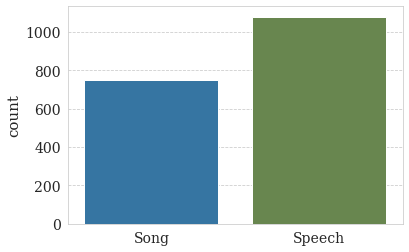

In [14]:
labels = ['Song','Speech']
ax=sns.countplot(x=df_vocal_channel_train['vocal_channel'], palette=['#2478b4','#678F46'])
ax.set_xticklabels(labels)
ax.set(xlabel=None)
ax.tick_params(axis='both', which='major', labelsize=14)
img_name = 'Before_Imbalancing_Vocal_Channel' + '.png'
#plt.savefig(img_name,dpi=300, bbox_inches='tight')
plt.show()

In [15]:
def rows_to_remove(data,target,num, dataset):
    
    y = dataset['y']
    
    majority_class = list(dataset['result'].keys())[1]
    
    total_majority_class = dataset['result'][majority_class]
    
    np.random.seed(42)
    
    rows_remove = np.random.choice((data[y == majority_class]).index, total_majority_class-num, replace=False)
    
    df_target = data.drop(index=rows_remove, axis=0)
    
    return {'df_target': df_target,
            'rows_remove': rows_remove}

In [16]:
rows_remove_train = rows_to_remove(df_vocal_channel_train,"vocal_channel", 31, dip_indp_variables_train)

In [17]:
def drop_rows(data, rows_dataset):
    
    df_after_remove = data.drop(index=rows_dataset['rows_remove'], axis=0)
    
    return {'df_after_remove': df_after_remove}

In [18]:
drop_rows_train = drop_rows(df_vocal_channel_train, rows_remove_train)

In [19]:
def dip_indip_after_remove(data, target, rows, dip_indp_variables_dataset):
    
    X2 = data.loc[:, data.columns != target]
    
    y2 = np.array([dip_indp_variables_dataset['y'][i] for i in range(len(dip_indp_variables_dataset['y'])) if i not in rows])
    
    result = np.unique(y2, return_counts=True)
    
    return {'X2': X2,
            'y2': y2,
            'result': { result[0][0] : result[1][0],
                      result[0][1] : result[1][1]}
           }

In [20]:
dip_indip_after_remove_train = dip_indip_after_remove(drop_rows_train['df_after_remove'], 
                                                'vocal_channel',
                                                rows_remove_train['rows_remove'], dip_indp_variables_train)

In [21]:
X2 = np.array(dip_indip_after_remove_train['X2'])
y2 = np.array(dip_indip_after_remove_train['y2'].ravel())

In [22]:
np.unique(y2, return_counts=True)

(array([0, 1]), array([748,  31]))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=0.3, random_state=100)

In [24]:
X_train.shape

(545, 392)

## Decision Tree before Undersampling/Oversampling

In [25]:
from scipy.stats import uniform, randint, loguniform
from sklearn.model_selection import RepeatedStratifiedKFold

In [26]:
def Decision_tree(X_train_array, y_train_array):
    
    param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": list(range(2,200)),
    "criterion": ["gini", "entropy", "log_loss"],
    
}


    tree = DecisionTreeClassifier(random_state=42)


    tree_cv = RandomizedSearchCV(tree, param_grid, cv=RepeatedStratifiedKFold(n_splits=5,random_state=42),
    n_jobs=-1,
    n_iter=200, error_score='raise')


    tree_cv.fit(X_train_array,y_train_array)

    return tree_cv

In [27]:
decision_tree = Decision_tree(X_train, y_train)

In [28]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 142, 'min_samples_leaf': 0.028823238828612374, 'min_samples_split': 0.015907033878686545}


In [29]:
model_tree = decision_tree.best_estimator_
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=142,
                       min_samples_leaf=0.028823238828612374,
                       min_samples_split=0.015907033878686545, random_state=42)

In [30]:
y_pred_decision_tree = model_tree.predict(X_test)

In [31]:
def metrics_model( test,predict, majority_class, minority_class):
    new_dic = {}
    new_dic['accuracy'] = accuracy_score(test,predict)
    #new_dic['precision ('+ majority_class + ')'] = precision_score(predict, test, average=None)[0]
    #new_dic['precision ('+ minority_class + ')'] = precision_score(predict, test,average=None)[1]
    #new_dic['recall ('+ majority_class + ')'] = recall_score(predict, test, average=None)[0]
    #new_dic['recall ('+ minority_class + ')'] = recall_score(predict, test, average=None)[1]
    new_dic['f1_score ('+ majority_class + ')'] = metrics.f1_score(test,predict, average=None)[0]
    new_dic['f1_score ('+ minority_class + ')'] = metrics.f1_score(test,predict, average=None)[1]
    
    return new_dic

In [32]:
data_decision_tree = metrics_model(y_test, y_pred_decision_tree, 'song', 'speech')
data_decision_tree

{'accuracy': 0.9700854700854701,
 'f1_score (song)': 0.9843400447427293,
 'f1_score (speech)': 0.6666666666666666}

In [33]:
print(classification_report(y_pred_decision_tree,y_test))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       222
           1       0.78      0.58      0.67        12

    accuracy                           0.97       234
   macro avg       0.88      0.79      0.83       234
weighted avg       0.97      0.97      0.97       234



## KNN before Undersampling/Oversampling

In [34]:
def spearman_selector(target, df, k):
    """Returns a df comprising all the features highly correlated (above k and below -k)
    with the binary target according Spearman coefficient. Target must be a pd Series"""
    df = df.select_dtypes(include="number")
    target = target.map({target.unique()[0]:0, target.unique()[1]:1})
    new_df = pd.DataFrame()
    for col in df:
        spearman = stats.spearmanr(df[col], target)[0]
        if spearman > k or spearman < -k:
            new_df[col] = df[col]
    return new_df

In [35]:
df_vocal_channel_train_knn = spearman_selector(df_train['vocal_channel'], df_train, 0.7)

/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [36]:
df_train_cat_knn = df_train.select_dtypes(include=['object'])
df_vocal_channel_train = pd.concat([df_vocal_channel_train_knn, df_train_cat_knn], axis=1)

In [37]:
df_vocal_channel_train = pd.get_dummies(df_vocal_channel_train)

In [38]:
dip_indp_variables_knn = dip_indp_variables(df_vocal_channel_train,"vocal_channel")

In [39]:
dip_indp_variables_knn['result']

{0: 748, 1: 1080}

In [40]:
dip_indp_variables_knn['X'].shape

(1828, 36)

In [41]:
rows_remove_knn = rows_to_remove(df_vocal_channel_train,"vocal_channel", 31, dip_indp_variables_knn)

In [42]:
drop_rows_knn = drop_rows(df_vocal_channel_train, rows_remove_knn)

In [43]:
dip_indip_after_remove_knn = dip_indip_after_remove(drop_rows_knn['df_after_remove'], 
                                                'vocal_channel',
                                                rows_remove_knn['rows_remove'], dip_indp_variables_knn)

In [44]:
X2_knn = np.array(dip_indip_after_remove_knn['X2'])
y2_knn = np.array(dip_indip_after_remove_knn['y2'].ravel())

In [45]:
np.unique(y2_knn, return_counts=True)

(array([0, 1]), array([748,  31]))

In [46]:
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X2_knn, y2_knn, test_size=0.3, random_state=100)

In [47]:
X_train_knn.shape

(545, 36)

In [48]:
def Knn(X_train_array, y_train_array):   
    
    knn = KNeighborsClassifier()
    
    parameters = {
        'n_neighbors': np.arange(2, X_train_array.shape[0]//2),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'cityblock', 'minkowski']
        }
    
    knn_cv = RandomizedSearchCV(knn,
                                parameters,
                                cv=RepeatedStratifiedKFold(n_splits= 5,random_state=42),
                                n_jobs=-1,
                                refit=True)
    
    knn_cv.fit(X_train_array, y_train_array)
    
    return knn_cv

In [49]:
knn = Knn(X_train_knn, y_train_knn)

In [50]:
print(knn.best_params_)

{'weights': 'distance', 'n_neighbors': 153, 'metric': 'cityblock'}


In [51]:
model_knn = knn.best_estimator_
model_knn.fit(X_train_knn, y_train_knn)

KNeighborsClassifier(metric='cityblock', n_neighbors=153, weights='distance')

In [52]:
y_pred_knn = model_knn.predict(X_test_knn)

In [53]:
data_knn= metrics_model( y_test_knn, y_pred_knn,'song', 'speech')
data_knn

{'accuracy': 0.9615384615384616,
 'f1_score (song)': 0.9803921568627451,
 'f1_score (speech)': 0.0}

In [54]:
print(classification_report(y_test_knn,y_pred_knn))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       225
           1       0.00      0.00      0.00         9

    accuracy                           0.96       234
   macro avg       0.48      0.50      0.49       234
weighted avg       0.92      0.96      0.94       234



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [55]:
def combined_results(data,data1):
    combined_dic = {'Decision_tree': data, 'Knn': data1}
    
    return combined_dic

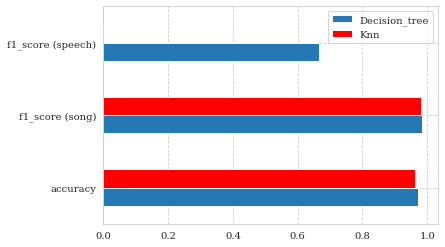

In [56]:
combined_dic = combined_results(data_decision_tree,data_knn)
df = pd.DataFrame(combined_dic)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('Imbalanced_Vocal_Channel_Result',dpi=300, bbox_inches='tight')
plt.show()

## Undersampling

In [57]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import EditedNearestNeighbours

## Random Undersampling

## KNN dopo Random Undersampling

In [58]:
acc_knn = []
f1_score_knn_song = []
f1_score_knn_speech = []



for i in range(10):
    rus = RandomUnderSampler()
    X_res_rus_knn, y_res_rus_knn = rus.fit_resample(X_train_knn, y_train_knn)
    
    # train a classifier on the balanced training set
    knn_under_rus = Knn(X_res_rus_knn, y_res_rus_knn)
    knn_best = knn_under_rus.best_estimator_
    
    knn_best.fit(X_res_rus_knn, y_res_rus_knn)
    
    # evaluate the classifier on the test set
    y_pred = knn_best.predict(X_test_knn)
    f1_score_knn = metrics.f1_score(y_test_knn, y_pred, average=None)
    acc = accuracy_score(y_test_knn, y_pred)
    acc_knn.append(acc)
    f1_score_knn_song.append(f1_score_knn[0])
    f1_score_knn_speech.append(f1_score_knn[1])
    
    
#print(f'Accuracy: {acc_knn}')
#print(f'f1_score_song: {f1_score_knn_song}')
#print(f'f1_score_speech: {f1_score_knn_speech}')

In [59]:
knn_rus = {}
knn_rus['accuracy'] = sum(acc_knn)/len(acc_knn)
knn_rus['f1_score (song)'] = sum(f1_score_knn_song)/len(f1_score_knn_song)
knn_rus['f1_score (speech)'] = sum(f1_score_knn_speech)/len(f1_score_knn_speech)
print(knn_rus)

{'accuracy': 0.9136752136752138, 'f1_score (song)': 0.9529640785533153, 'f1_score (speech)': 0.4658893791744836}


## Decision Tree dopo Random Undersampling

In [60]:
acc_dt = []
f1_score_dt_song = []
f1_score_dt_speech = []


for i in range(10):
    rus = RandomUnderSampler(random_state=42)
    X_rus, y_rus = rus.fit_resample(X_train, y_train)
    
    # train a classifier on the balanced training set
    dt_under_rus = Decision_tree(X_rus, y_rus)
    dt_best = dt_under_rus.best_estimator_
    
    dt_best.fit(X_rus, y_rus)
    
    # evaluate the classifier on the test set
    y_pred_dt = dt_best.predict(X_test)
    f1_score_dt = metrics.f1_score(y_test, y_pred_dt, average=None)
    acc = accuracy_score(y_test, y_pred_dt)
    acc_dt.append(acc)
    f1_score_dt_song.append(f1_score_dt[0])
    f1_score_dt_speech.append(f1_score_dt[1])
   
#print(f'Accuracy: {acc_dt}')
#print(f'f1_score_first_class: {f1_score_dt_song}')
#print(f'f1_score_second_class: {f1_score_dt_speech}')

In [61]:
dt_rus = {}
dt_rus['accuracy'] = sum(acc_dt)/len(acc_dt)
dt_rus['f1_score (song)'] = sum(f1_score_dt_song)/len(f1_score_dt_song)
dt_rus['f1_score (speech)'] = sum(f1_score_dt_speech)/len(f1_score_dt_speech)
print(dt_rus)

{'accuracy': 0.9658119658119657, 'f1_score (song)': 0.9820627802690585, 'f1_score (speech)': 0.6363636363636365}


## EditedNearestNeighbors

In [62]:
def enn(X_train_array, y_train_array):
    
    enn = EditedNearestNeighbours()
    
    X_res_enn, y_res_enn = enn.fit_resample(X_train_array, y_train_array)
    
    return X_res_enn, y_res_enn

In [63]:
X_res_enn, y_res_enn = enn(X_train, y_train)

In [64]:
X_res_enn_knn, y_res_enn_knn = enn(X_train_knn, y_train_knn)

In [65]:
print('Resampled dataset shape %s' % Counter(y_res_enn))

Resampled dataset shape Counter({0: 517, 1: 22})


In [66]:
print('Resampled dataset shape %s' % Counter(y_res_enn_knn))

Resampled dataset shape Counter({0: 509, 1: 22})


In [67]:
len(X_res_enn)

539

In [68]:
len(X_res_enn_knn)

531

## KNN after EditedNearestNeighbors

In [69]:
knn_under_enn = Knn(X_res_enn_knn, y_res_enn_knn)

In [70]:
print(knn_under_enn.best_params_)

{'weights': 'distance', 'n_neighbors': 23, 'metric': 'cityblock'}


In [71]:
model_knn_enn = knn_under_enn.best_estimator_
model_knn_enn.fit(X_res_enn_knn, y_res_enn_knn)

KNeighborsClassifier(metric='cityblock', n_neighbors=23, weights='distance')

In [72]:
y_pred_knn_under_enn = model_knn_enn.predict(X_test_knn)

In [73]:
knn_enn = metrics_model(y_test_knn, y_pred_knn_under_enn, 'song', 'speech')
knn_enn

{'accuracy': 0.9615384615384616,
 'f1_score (song)': 0.9803921568627451,
 'f1_score (speech)': 0.0}

In [74]:
print(classification_report( y_pred_knn_under_enn, y_test_knn))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98       234
           1       0.00      0.00      0.00         0

    accuracy                           0.96       234
   macro avg       0.50      0.48      0.49       234
weighted avg       1.00      0.96      0.98       234



/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/blertalleshi/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Decision Tree after EditedNearestNeighbors

In [75]:
decision_tree_under_enn = Decision_tree(X_res_enn, y_res_enn)

In [76]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_under_enn.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 182, 'min_samples_leaf': 0.038302202500811955, 'min_samples_split': 0.022616154359995585}


In [77]:
model_tree_enn = decision_tree_under_enn.best_estimator_
model_tree_enn.fit(X_res_enn, y_res_enn)

DecisionTreeClassifier(criterion='entropy', max_depth=182,
                       min_samples_leaf=0.038302202500811955,
                       min_samples_split=0.022616154359995585, random_state=42)

In [78]:
y_pred_decision_tree_under_enn = model_tree_enn.predict(X_test)

In [79]:
decision_tree_enn = metrics_model(y_test,y_pred_decision_tree_under_enn, 'song', 'speech')
decision_tree_enn

{'accuracy': 0.9700854700854701,
 'f1_score (song)': 0.9843400447427293,
 'f1_score (speech)': 0.6666666666666666}

In [80]:
print(classification_report(y_test, y_pred_decision_tree_under_enn))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       225
           1       0.58      0.78      0.67         9

    accuracy                           0.97       234
   macro avg       0.79      0.88      0.83       234
weighted avg       0.98      0.97      0.97       234



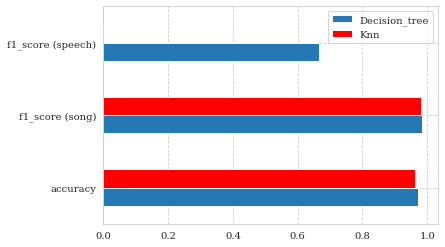

In [81]:
combined_dic_enn = combined_results(decision_tree_enn,knn_enn)
df = pd.DataFrame(combined_dic_enn)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('dddd',dpi=300, bbox_inches='tight')
plt.show()

## Oversampling

In [82]:
from imblearn.over_sampling import SMOTE

## SMOTE

In [83]:
def smote(X_train_array, y_train_array):
    
    sm = SMOTE(random_state=42, k_neighbors=9)
    
    X_res_sm, y_res_sm = sm.fit_resample(X_train_array, y_train_array)
    
    return X_res_sm, y_res_sm

In [84]:
X_res_sm, y_res_sm = smote(X_train, y_train)

In [85]:
X_res_sm_knn, y_res_sm_knn = smote(X_train_knn, y_train_knn)

In [86]:
print('Resampled dataset shape %s' % Counter(y_res_sm))

Resampled dataset shape Counter({0: 523, 1: 523})


In [87]:
len(X_train)

545

In [88]:
len(X_train_knn)

545

## KNN after SMOTE

In [89]:
knn_over_sm = Knn(X_res_sm_knn, y_res_sm_knn)

In [90]:
print(knn_over_sm.best_params_)

{'weights': 'uniform', 'n_neighbors': 59, 'metric': 'cityblock'}


In [91]:
model_knn_smote = knn_over_sm.best_estimator_
model_knn_smote.fit(X_res_sm_knn, y_res_sm_knn)

KNeighborsClassifier(metric='cityblock', n_neighbors=59)

In [92]:
y_pred_knn_over_sm = model_knn_smote.predict(X_test_knn)

In [93]:
knn_smote = metrics_model( y_test_knn, y_pred_knn_over_sm, 'song', 'speech')
knn_smote

{'accuracy': 0.9700854700854701,
 'f1_score (song)': 0.9842696629213483,
 'f1_score (speech)': 0.6956521739130435}

In [94]:
print(classification_report(y_test_knn, y_pred_knn_over_sm))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       225
           1       0.57      0.89      0.70         9

    accuracy                           0.97       234
   macro avg       0.78      0.93      0.84       234
weighted avg       0.98      0.97      0.97       234



## Decision Tree after SMOTE

In [95]:
decision_tree_over_sm = Decision_tree(X_res_sm, y_res_sm)

In [96]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_over_sm.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': 148, 'min_samples_leaf': 0.0033710586420487845, 'min_samples_split': 0.017807452427873457}


In [97]:
model_tree_smote = decision_tree_over_sm.best_estimator_
model_tree_smote.fit(X_res_sm, y_res_sm)

DecisionTreeClassifier(criterion='entropy', max_depth=148,
                       min_samples_leaf=0.0033710586420487845,
                       min_samples_split=0.017807452427873457, random_state=42)

In [98]:
y_pred_decision_tree_over_sm = model_tree_smote.predict(X_test)

In [99]:
decision_tree_smote = metrics_model(y_test, y_pred_decision_tree_over_sm, 'song', 'speech')
decision_tree_smote

{'accuracy': 0.9529914529914529,
 'f1_score (song)': 0.9755011135857461,
 'f1_score (speech)': 0.4210526315789474}

In [100]:
print(classification_report(y_test, y_pred_decision_tree_over_sm))

              precision    recall  f1-score   support

           0       0.98      0.97      0.98       225
           1       0.40      0.44      0.42         9

    accuracy                           0.95       234
   macro avg       0.69      0.71      0.70       234
weighted avg       0.96      0.95      0.95       234



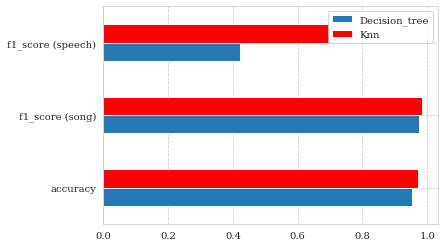

In [101]:
combined_dic_smote = combined_results(decision_tree_smote,knn_smote)
df = pd.DataFrame(combined_dic_smote)
df.plot(kind='barh', color=['#2478b4','red'])
#plt.savefig('SMOTE_Vocal_Channel_Result',dpi=300, bbox_inches='tight')
plt.show()

## Decision Tree with class weight

In [102]:
def Decision_tree_cw(X_train_array, y_train_array):
    
    param_grid = {
    "min_samples_split": loguniform(1e-2, 1e0),
    "min_samples_leaf": uniform(0.001, 0.2),
    "max_depth": list(range(2,200)),
    "criterion": ["gini", "entropy", "log_loss"],
    
}


    tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')


    tree_cv = RandomizedSearchCV(tree, 
                                 param_grid, 
                                 cv=RepeatedStratifiedKFold(n_splits=5,random_state=42),
                                 n_jobs=-1,
                                 n_iter=200, 
                                 error_score='raise')


    tree_cv.fit(X_train_array,y_train_array)

    return tree_cv

In [103]:
decision_tree_cl = Decision_tree_cw(X_train, y_train)

In [104]:
print("Tuned Decision Tree Parameters: {}".format(decision_tree_cl.best_params_))

Tuned Decision Tree Parameters: {'criterion': 'gini', 'max_depth': 172, 'min_samples_leaf': 0.005006876815443028, 'min_samples_split': 0.019140737794545025}


In [105]:
model_tree_cl = decision_tree_cl.best_estimator_
model_tree_cl.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', max_depth=172,
                       min_samples_leaf=0.005006876815443028,
                       min_samples_split=0.019140737794545025, random_state=42)

In [106]:
y_pred_decision_tree_cl = model_tree_cl.predict(X_test)

In [107]:
decision_tree_cl = metrics_model(y_test, y_pred_decision_tree_cl, 'song', 'speech')
decision_tree_cl

{'accuracy': 0.9615384615384616,
 'f1_score (song)': 0.9797752808988764,
 'f1_score (speech)': 0.6086956521739131}

In [108]:
print(classification_report(y_test, y_pred_decision_tree_cl))

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       225
           1       0.50      0.78      0.61         9

    accuracy                           0.96       234
   macro avg       0.75      0.87      0.79       234
weighted avg       0.97      0.96      0.97       234



In [142]:
def combined_results_final_knn(data,  data2, data3):
    
    combined_dic = {'Before Balancing': data, 
                   'Random Undersampling': data2,
                   'SMOTE': data3}
    
    return combined_dic

In [143]:
def combined_results_final_dt(data,  data2, data3,data4):
    
    combined_dic = {'Before Balancing': data, 
                   'Random Undersampling': data2,
                   'SMOTE': data3,
                   'Class balanced': data4}
    
    return combined_dic

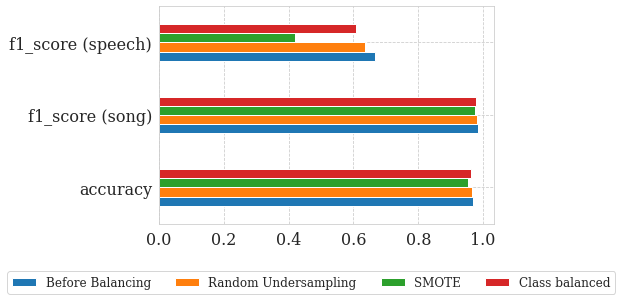

In [144]:
combined_dic_dt = combined_results_final_dt(data_decision_tree,  dt_rus, decision_tree_smote, decision_tree_cl)
df = pd.DataFrame(combined_dic_dt)
ax = df.plot(kind='barh')
ax.legend(loc='lower right',bbox_to_anchor=(1.38,-0.35),prop={'size': 12},ncol=4)
plt.tick_params(axis='both', which='major', labelsize=16)
#plt.savefig('Decision_Tree_Result_VC',dpi=300, bbox_inches='tight')
plt.show()

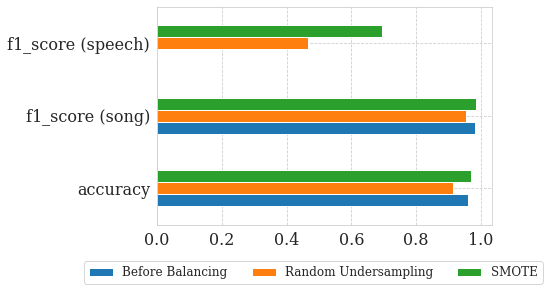

In [145]:
combined_dic_knn = combined_results_final_knn(data_knn,  knn_rus, knn_smote)
df = pd.DataFrame(combined_dic_knn)
ax = df.plot(kind='barh')
ax.legend(loc='lower right',bbox_to_anchor=(1.17,-0.3),prop={'size': 12},ncol=3)
ax.tick_params(axis='both', which='major', labelsize=16)
#plt.savefig('KNN_Result_VC',dpi=300, bbox_inches='tight')
plt.show()